Dependencies will be tested between existing features and constructed features with the fraud tags

- constructed numerical feature: fraud proportion of the same card/ip address/email in the past
- constructed categorical boolean feature: anonymous (ip address, email address)

In [71]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline
%load_ext autoreload
%autoreload

df = pd.read_csv('adyen-dataset.csv')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
df.head()

,psp_reference,merchant,card_scheme,year,hour_of_day,minute_of_hour,day_of_year,is_credit,eur_amount,ip_country,issuing_country,device_type,ip_address,email_address,card_number,shopper_interaction,zip_code,card_bin,has_fraudulent_dispute,is_refused_by_adyen
0,79622457320,Merchant A,Other,2021,13,51,206,True,18.75,GR,GR,MacOS,i1oY1kTOXMlsFfoyhFJxyA,3XBRYto3QgX7g4pX-BvNyA,XldVNN9TQgIA2RE9FTC2TA,Ecommerce,XDED,4236,False,False
1,41293916020,Merchant C,Visa,2021,15,20,345,False,43.65,BR,BR,Android,HZkxQvtpScNLgi0fsoSkjA,klwgzdfrnz_6eGsHSi2prQ,zgRoL8pxX5LJI-SEPUTMvg,Ecommerce,AAD,4802,False,False
2,31382555255,Merchant E,Visa,2021,1,56,293,True,187.72,NL,NL,MacOS,HGW5EwBnHVgOrD5xYplBdw,XkMWeLLmXALPcV3ndwzKJw,T3BF1uOOqgcwaVRb_ujPQg,Ecommerce,1104,4526,False,False
3,13944051314,Merchant D,Visa,2021,12,50,242,False,109.16,NL,NL,iOS,8AuFEjK8m-0lxGAOJzOPmg,26Lw20NQtPKb5cyQZBuh1w,BMf1zFkJ1xvPMlOxC7RWTw,Ecommerce,2039,4571,False,True
4,62343575411,Merchant E,MasterCard,2021,19,26,318,True,46.27,BR,BR,Other,NaN,Y7tv2i85iUadkEIAPIufgg,jfxS2TIe0gR9vpOUdMKrBw,Ecommerce,XOL,4916,False,False


In [35]:
def to_date(year, days_of_year, hour, minute):
    date = datetime(year, 1, 1) + timedelta(days_of_year - 1)
    return datetime(year=date.year, month=date.month, day=date.day, hour=hour, minute=minute)
df['datetime'] = df.apply(lambda row: to_date(row['year'], row['day_of_year'], row['hour_of_day'], row['minute_of_hour']), axis=1)
dates_2021 = [datetime(2021, 1, 1) + timedelta(days=i) for i in range(365)]

In [36]:
df.head()

,psp_reference,merchant,card_scheme,year,hour_of_day,minute_of_hour,day_of_year,is_credit,eur_amount,ip_country,...,device_type,ip_address,email_address,card_number,shopper_interaction,zip_code,card_bin,has_fraudulent_dispute,is_refused_by_adyen,datetime
0,79622457320,Merchant A,Other,2021,13,51,206,True,18.75,GR,...,MacOS,i1oY1kTOXMlsFfoyhFJxyA,3XBRYto3QgX7g4pX-BvNyA,XldVNN9TQgIA2RE9FTC2TA,Ecommerce,XDED,4236,False,False,2021-07-25 13:51:00
1,41293916020,Merchant C,Visa,2021,15,20,345,False,43.65,BR,...,Android,HZkxQvtpScNLgi0fsoSkjA,klwgzdfrnz_6eGsHSi2prQ,zgRoL8pxX5LJI-SEPUTMvg,Ecommerce,AAD,4802,False,False,2021-12-11 15:20:00
2,31382555255,Merchant E,Visa,2021,1,56,293,True,187.72,NL,...,MacOS,HGW5EwBnHVgOrD5xYplBdw,XkMWeLLmXALPcV3ndwzKJw,T3BF1uOOqgcwaVRb_ujPQg,Ecommerce,1104,4526,False,False,2021-10-20 01:56:00
3,13944051314,Merchant D,Visa,2021,12,50,242,False,109.16,NL,...,iOS,8AuFEjK8m-0lxGAOJzOPmg,26Lw20NQtPKb5cyQZBuh1w,BMf1zFkJ1xvPMlOxC7RWTw,Ecommerce,2039,4571,False,True,2021-08-30 12:50:00
4,62343575411,Merchant E,MasterCard,2021,19,26,318,True,46.27,BR,...,Other,NaN,Y7tv2i85iUadkEIAPIufgg,jfxS2TIe0gR9vpOUdMKrBw,Ecommerce,XOL,4916,False,False,2021-11-14 19:26:00


In [28]:
df_all = df.sort_values(by="datetime")
df_all.name = "all"
df_fraud = df[df["has_fraudulent_dispute"] == True]
df_fraud.name = "fraud"
df_non_fraud = df[df["has_fraudulent_dispute"] == False]
df_non_fraud.name = "non-fraud"

# 1. TIME of TRANSACTION
## 1.1 Activity per day:

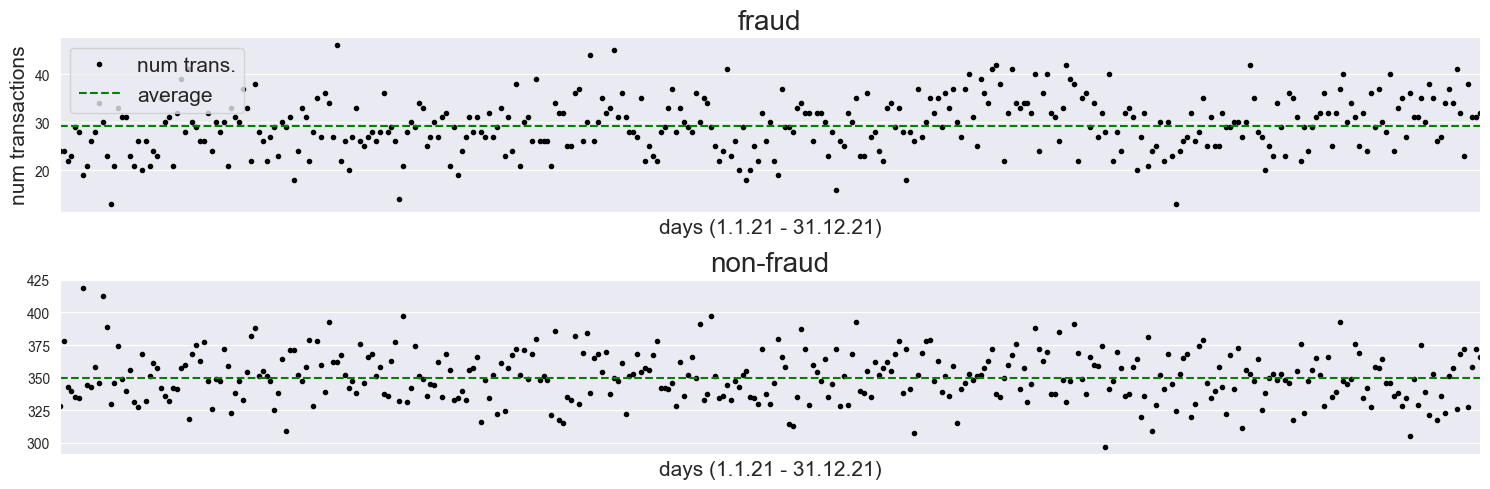

In [33]:
plt.figure(figsize=(15, 5))
plt_idx = 1
for d in [df_fraud, df_non_fraud]:
    plt.subplot(2, 1, plt_idx)
    trans_dates = d["datetime"].apply(lambda date: date.date())
    all_trans = trans_dates.value_counts().sort_index()
    date_num = matplotlib.dates.date2num(all_trans.index)
    plt.plot(date_num, all_trans.values, 'k.', label='num trans.')
    plt.plot(date_num, np.zeros(len(date_num))+np.sum(all_trans)/366, 'g--',label='average')
    plt_idx += 1
    plt.title(d.name, size=20)
    plt.xlabel('days (1.1.21 - 31.12.21)', size=15)
    plt.xticks([])
    plt.xlim(matplotlib.dates.date2num([datetime(2021,1,1), datetime(2021,12,31)]))
    if plt_idx == 2:
        plt.ylabel('num transactions', size=15)
        plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

# 1.2 Activity per day in a month

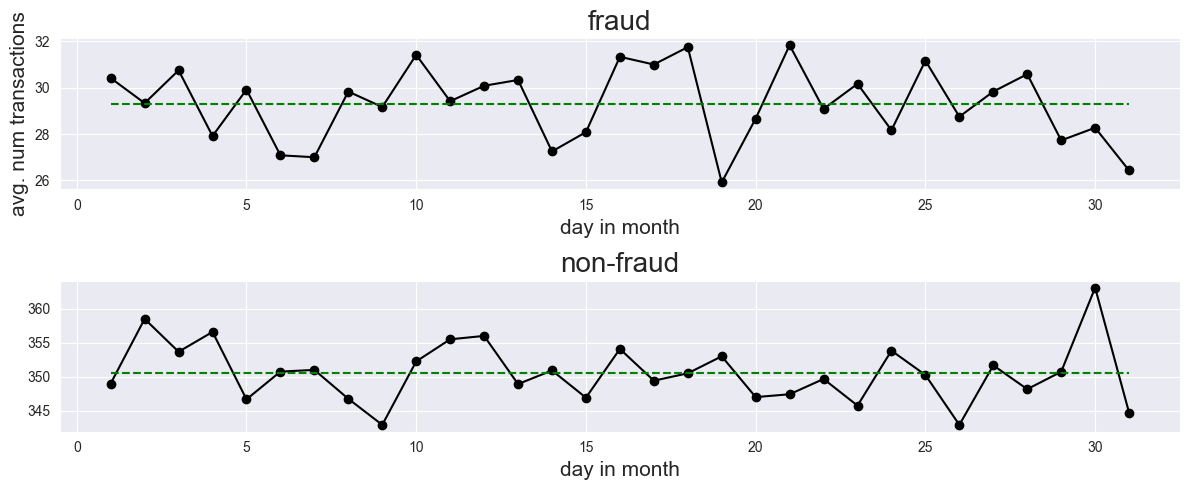

In [51]:
monthdays_2021 = np.unique([dates_2021[i].day for i in range(365)], return_counts=True)
monthdays_2021 = monthdays_2021[1][monthdays_2021[0]-1]  # days for each month

plt.figure(figsize=(12, 5))
plt_idx = 1
monthday_frac = np.zeros((31, 2))
idx = 0
for d in [df_fraud, df_non_fraud]:

    # get the average number of transactions per day in a month
    monthday = d["datetime"].apply(lambda date: date.day).value_counts().sort_index()
    monthday /= monthdays_2021
    if idx > -1:
        monthday_frac[:, idx] = monthday.values / np.sum(monthday.values, axis=0)
    idx += 1

    plt.subplot(2, 1, plt_idx)
    plt.plot(monthday.index, monthday.values, 'ko')
    plt.plot(monthday.index, monthday.values, 'k-', markersize=0.1)

    plt.plot(monthday.index, np.zeros(31)+np.sum(monthday)/31, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('day in month', size=15)
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1
plt.tight_layout()
plt.show()

# 1.3 Activity per weekday

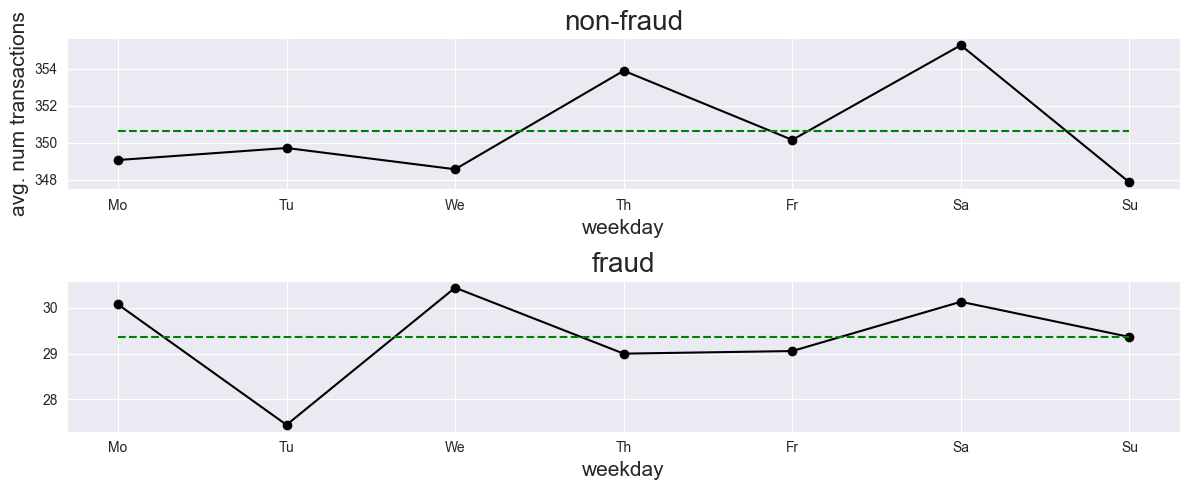

In [84]:
weekdays_2021 = np.unique([dates_2021[i].weekday() for i in range(365)], return_counts=True)
weekdays_2021 = weekdays_2021[1][weekdays_2021[0]]

plt.figure(figsize=(12, 5))
plt_idx = 1
weekday_frac = np.zeros((7, 2))
idx = 0
for d in [df_non_fraud, df_fraud]:

    weekday = d["datetime"].apply(lambda date: date.weekday()).value_counts().sort_index()
    weekday /= weekdays_2021
    if idx > -1:
        weekday_frac[:, idx] = weekday.values / np.sum(weekday.values, axis=0)
    idx += 1

    plt.subplot(2, 1, plt_idx)
    plt.plot(weekday.index, weekday.values, 'ko')
    plt.plot(weekday.index, weekday.values, 'k-', markersize=0.1)
    plt.plot(weekday.index, np.zeros(7)+np.sum(weekday)/7, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('weekday', size=15)
    plt.xticks(range(7), ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1
plt.tight_layout()
plt.show()

# 1.4  Activity per month in a year

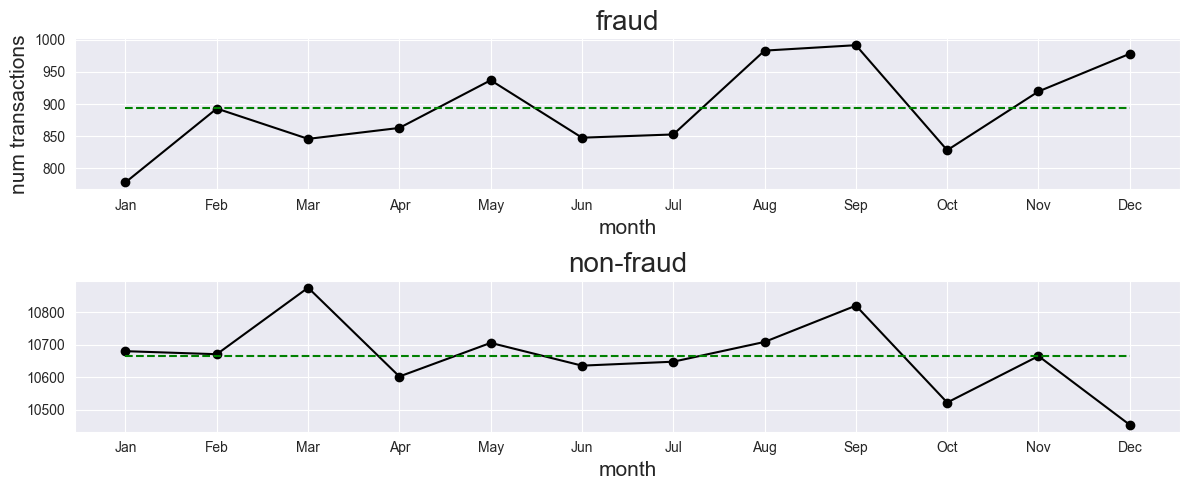

In [67]:
monthdays = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

plt.figure(figsize=(12, 5))
plt_idx = 1

month_frac = np.zeros((12, 2))
idx = 0
for d in [df_fraud, df_non_fraud]:

    month = d["datetime"].apply(lambda date: date.month).value_counts().sort_index()
    # correct for different number of days in a month
    month = month / monthdays[month.index.values-1] * np.mean(monthdays[month.index.values-1])

    if idx > -1:
        month_frac[month.index-1, idx] = month.values / np.sum(month.values, axis=0)
    idx += 1

    plt.subplot(2, 1, plt_idx)
    plt.plot(month.index, month.values, 'ko')
    plt.plot(month.index, month.values, 'k-', markersize=0.1)
    plt.plot(range(1,13), np.zeros(12)+np.sum(month)/12, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('month', size=15)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if plt_idx == 1:
        plt.ylabel('num transactions', size=15)
    plt_idx += 1

plt.tight_layout()
plt.show()

# Activity per hour of day:

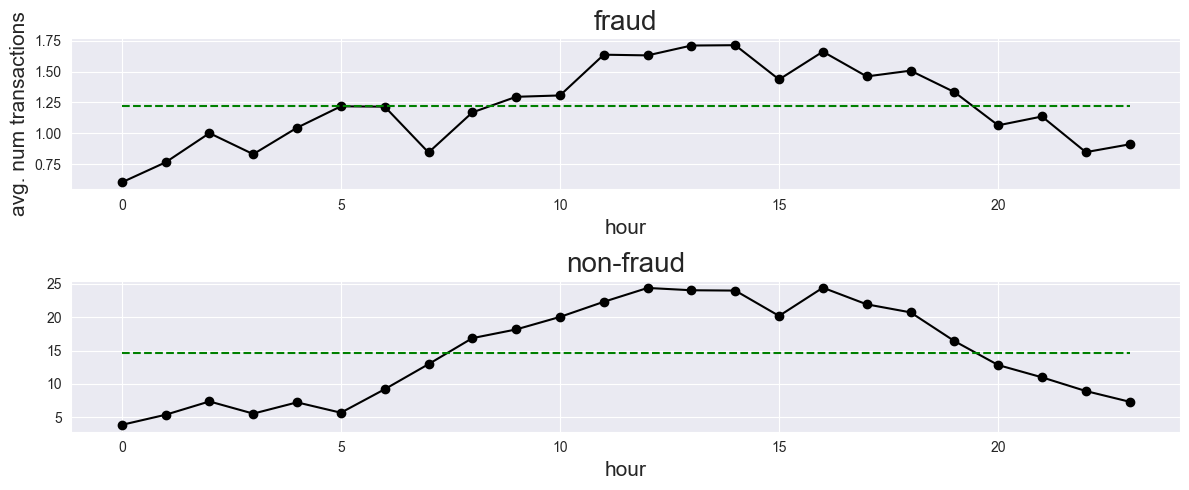

In [66]:
plt.figure(figsize=(12, 5))
plt_idx = 1

hour_frac = np.zeros((24, 2))
idx = 0
for d in [df_fraud, df_non_fraud]:

    hours = d["datetime"].apply(lambda date: date.hour).value_counts().sort_index()
    hours /= 365

    if idx > -1:
        hour_frac[hours.index.values, idx] = hours.values / np.sum(hours.values, axis=0)
    idx += 1

    plt.subplot(2, 1, plt_idx)
    plt.plot(hours.index, hours.values, 'ko')
    plt.plot(hours.index, hours.values, 'k-', markersize=0.1, label='transactions')
    plt.plot(range(24), np.zeros(24)+np.sum(hours)/24, 'g--', label='average')
    plt.title(d.name, size=20)
    plt.xlabel('hour', size=15)
    # plt.xticks([])
    if plt_idx == 1:
        plt.ylabel('avg. num transactions', size=15)
    plt_idx += 1

plt.tight_layout()
plt.show()


# Country
# ip_country

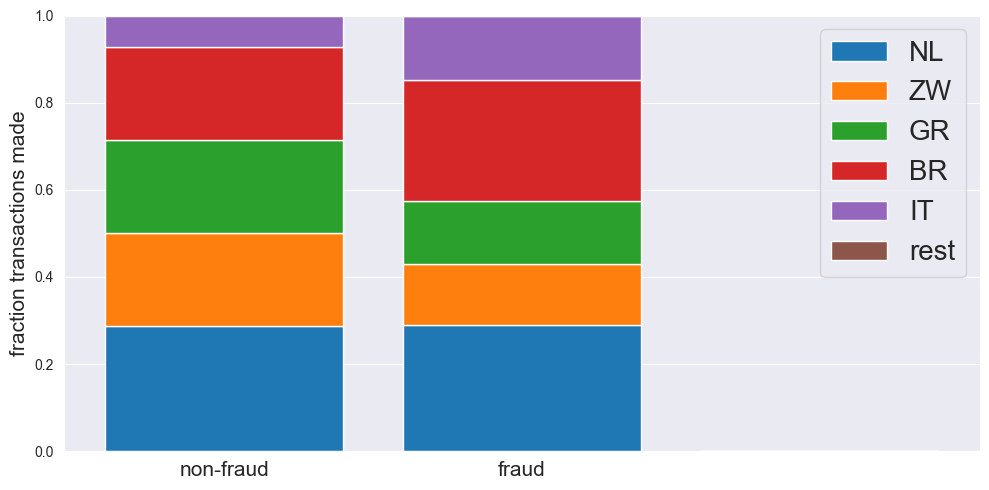

In [94]:
country_counts = pd.concat([d['ip_country'].value_counts() for d in [df_non_fraud, df_fraud]], axis=1)
country_counts.fillna(0, inplace=True)
country_counts.columns = ['non-fraud', 'fraud']
country_counts[['non-fraud', 'fraud']] /= country_counts.sum(axis=0)

countries_large = []
for c in ['non-fraud', 'fraud']:
    countries_large.extend(country_counts.loc[country_counts[c] > 0.05].index)
countries_large = np.unique(countries_large)

countries_large_counts = []
for c in countries_large:
    countries_large_counts.append(country_counts.loc[c, 'non-fraud'])
countries_large = [countries_large[np.argsort(countries_large_counts)[::-1][i]] for i in range(len(countries_large))]

plt.figure(figsize=(10,5))
bottoms = np.zeros(3)
for i in range(len(countries_large)):
    c = countries_large[i]
    plt.bar((0, 1, 2), np.concatenate((country_counts.loc[c], [0])), label=c, bottom=bottoms)
    bottoms += np.concatenate((country_counts.loc[c], [0]))
# fill up the rest
plt.bar((0, 1), 1-bottoms[:-1], bottom=bottoms[:-1], label='rest')
plt.legend(fontsize=20)
plt.xticks([0, 1], ['non-fraud', 'fraud'], size=15)
plt.ylabel('fraction transactions made', size=15)
plt.tight_layout()
plt.show()

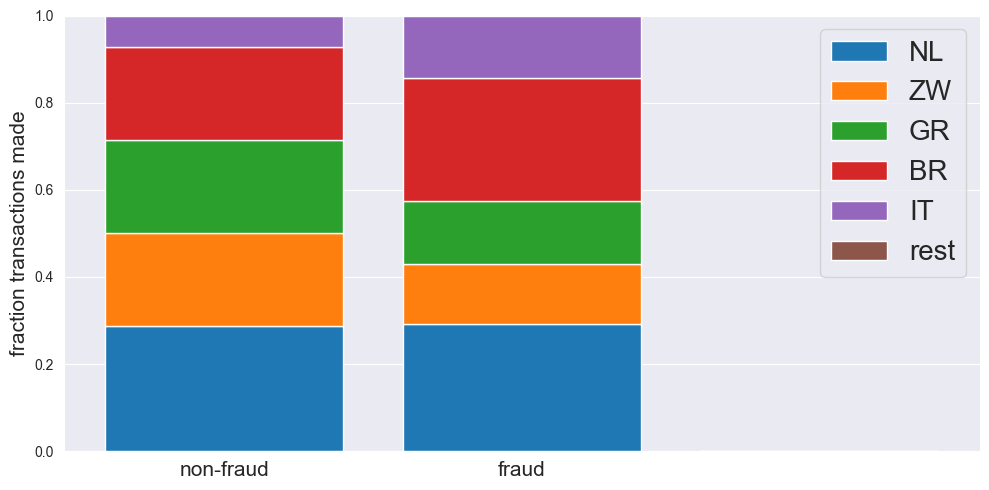

In [96]:
## issuing_country
country_counts = pd.concat([d['issuing_country'].value_counts() for d in [df_non_fraud, df_fraud]], axis=1)
country_counts.fillna(0, inplace=True)
country_counts.columns = ['non-fraud', 'fraud']
country_counts[['non-fraud', 'fraud']] /= country_counts.sum(axis=0)

countries_large = []
for c in ['non-fraud', 'fraud']:
    countries_large.extend(country_counts.loc[country_counts[c] > 0.05].index)
countries_large = np.unique(countries_large)

countries_large_counts = []
for c in countries_large:
    countries_large_counts.append(country_counts.loc[c, 'non-fraud'])
countries_large = [countries_large[np.argsort(countries_large_counts)[::-1][i]] for i in range(len(countries_large))]

plt.figure(figsize=(10,5))
bottoms = np.zeros(3)
for i in range(len(countries_large)):
    c = countries_large[i]
    plt.bar((0, 1, 2), np.concatenate((country_counts.loc[c], [0])), label=c, bottom=bottoms)
    bottoms += np.concatenate((country_counts.loc[c], [0]))
# fill up the rest
plt.bar((0, 1), 1-bottoms[:-1], bottom=bottoms[:-1], label='rest')
plt.legend(fontsize=20)
plt.xticks([0, 1], ['non-fraud', 'fraud'], size=15)
plt.ylabel('fraction transactions made', size=15)
plt.tight_layout()
plt.show()

## zip_code

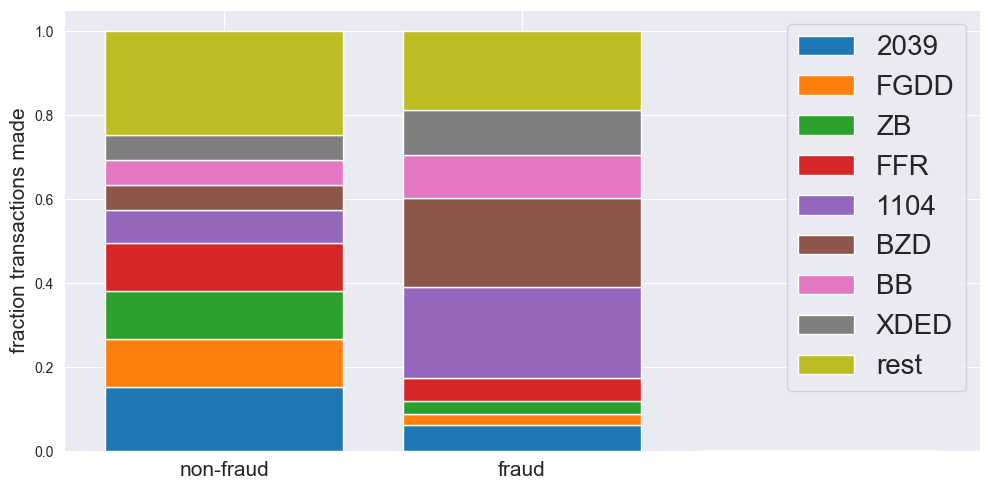

In [98]:
plt.show()
## issuing_country
country_counts = pd.concat([d['zip_code'].value_counts() for d in [df_non_fraud, df_fraud]], axis=1)
country_counts.fillna(0, inplace=True)
country_counts.columns = ['non-fraud', 'fraud']
country_counts[['non-fraud', 'fraud']] /= country_counts.sum(axis=0)

countries_large = []
for c in ['non-fraud', 'fraud']:
    countries_large.extend(country_counts.loc[country_counts[c] > 0.05].index)
countries_large = np.unique(countries_large)

countries_large_counts = []
for c in countries_large:
    countries_large_counts.append(country_counts.loc[c, 'non-fraud'])
countries_large = [countries_large[np.argsort(countries_large_counts)[::-1][i]] for i in range(len(countries_large))]

plt.figure(figsize=(10, 5))
bottoms = np.zeros(3)
for i in range(len(countries_large)):
    c = countries_large[i]
    plt.bar((0, 1, 2), np.concatenate((country_counts.loc[c], [0])), label=c, bottom=bottoms)
    bottoms += np.concatenate((country_counts.loc[c], [0]))
# fill up the rest
plt.bar((0, 1), 1 - bottoms[:-1], bottom=bottoms[:-1], label='rest')
plt.legend(fontsize=20)
plt.xticks([0, 1], ['non-fraud', 'fraud'], size=15)
plt.ylabel('fraction transactions made', size=15)
plt.tight_layout()
plt.show()

In [99]:
df_fraud[df_fraud["zip_code"] == "1104"]

,psp_reference,merchant,card_scheme,year,hour_of_day,minute_of_hour,day_of_year,is_credit,eur_amount,ip_country,...,device_type,ip_address,email_address,card_number,shopper_interaction,zip_code,card_bin,has_fraudulent_dispute,is_refused_by_adyen,datetime
13,21696416452,Merchant B,Amex,2021,18,21,328,True,23.92,NL,...,Linux,NaN,VifmXDu_B8czGx3rDcO2Lg,p2bugYfCBQea6u47vcT8NA,Ecommerce,1104,4916,True,False,2021-11-24 18:21:00
68,75817616343,Merchant B,Visa,2021,2,6,343,True,429.99,NL,...,Other,OLLEETTxZYCxiaF2I0rgoA,7ccmnLtikrLTC2fkYZhPng,A7vsHBUG6or-3iOkzqG8jA,Ecommerce,1104,4920,True,False,2021-12-09 02:06:00
76,56779726720,Merchant A,Visa,2021,5,17,70,True,385.93,NL,...,Other,zsQmatJ4L9CKaRuE_hQyaw,WXFht3W_uBYJl8l-j-uDCg,Gnp3sOkBMhqQBT_2BaDPSg,Ecommerce,1104,4622,True,False,2021-03-11 05:17:00
100,35016462890,Merchant E,Visa,2021,5,25,164,True,172.11,NL,...,Linux,NaN,Rnvfc65F9_wgOuZY2q9ZlQ,gDM5h9Kej08QiouwTjKwNg,Ecommerce,1104,4556,True,False,2021-06-13 05:25:00
107,77171937255,Merchant B,Other,2021,17,16,31,True,12.95,NL,...,Other,AvBv5ENMXbk0AJjCeHDvpw,4lXivpnbBQaN0LM_fnTMlg,iG2kSyCk0GO1fr2vAxTkqg,Ecommerce,1104,4916,True,False,2021-01-31 17:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138561,44845149217,Merchant A,Visa,2021,3,3,309,True,71.63,NL,...,iOS,NaN,kCPJCPgcADQgimWcx1-I1w,YuyevybAzhGC4208mQp8fw,Ecommerce,1104,4133,True,False,2021-11-05 03:03:00
138562,61406793550,Merchant A,Visa,2021,14,18,165,True,79.17,NL,...,Windows,uRfMkWHyBsgJATFM9LetRQ,rWd9PkD077z6sVFG3cNf6Q,ItPJNkYnMY1bEg0JO93VlQ,Ecommerce,1104,4920,True,False,2021-06-14 14:18:00
138640,65416975882,Merchant C,MasterCard,2021,4,42,187,True,53.20,NL,...,Android,0rx9WuCT_D878rsoHJRLQA,MPPAIWAtUda8O0J39qk0jw,zlrkRs42-jYFBd0CqV3DnQ,Ecommerce,1104,4556,True,False,2021-07-06 04:42:00
138641,58768750608,Merchant B,MasterCard,2021,8,11,115,True,40.70,NL,...,Android,ErLmydlrJtmMpke8gxdb5g,tb1RQGb-TwomXG6UH1UMvA,3gTBtkE0SAiUi-T7E3VpPw,Ecommerce,1104,4916,True,False,2021-04-25 08:11:00


# Customers

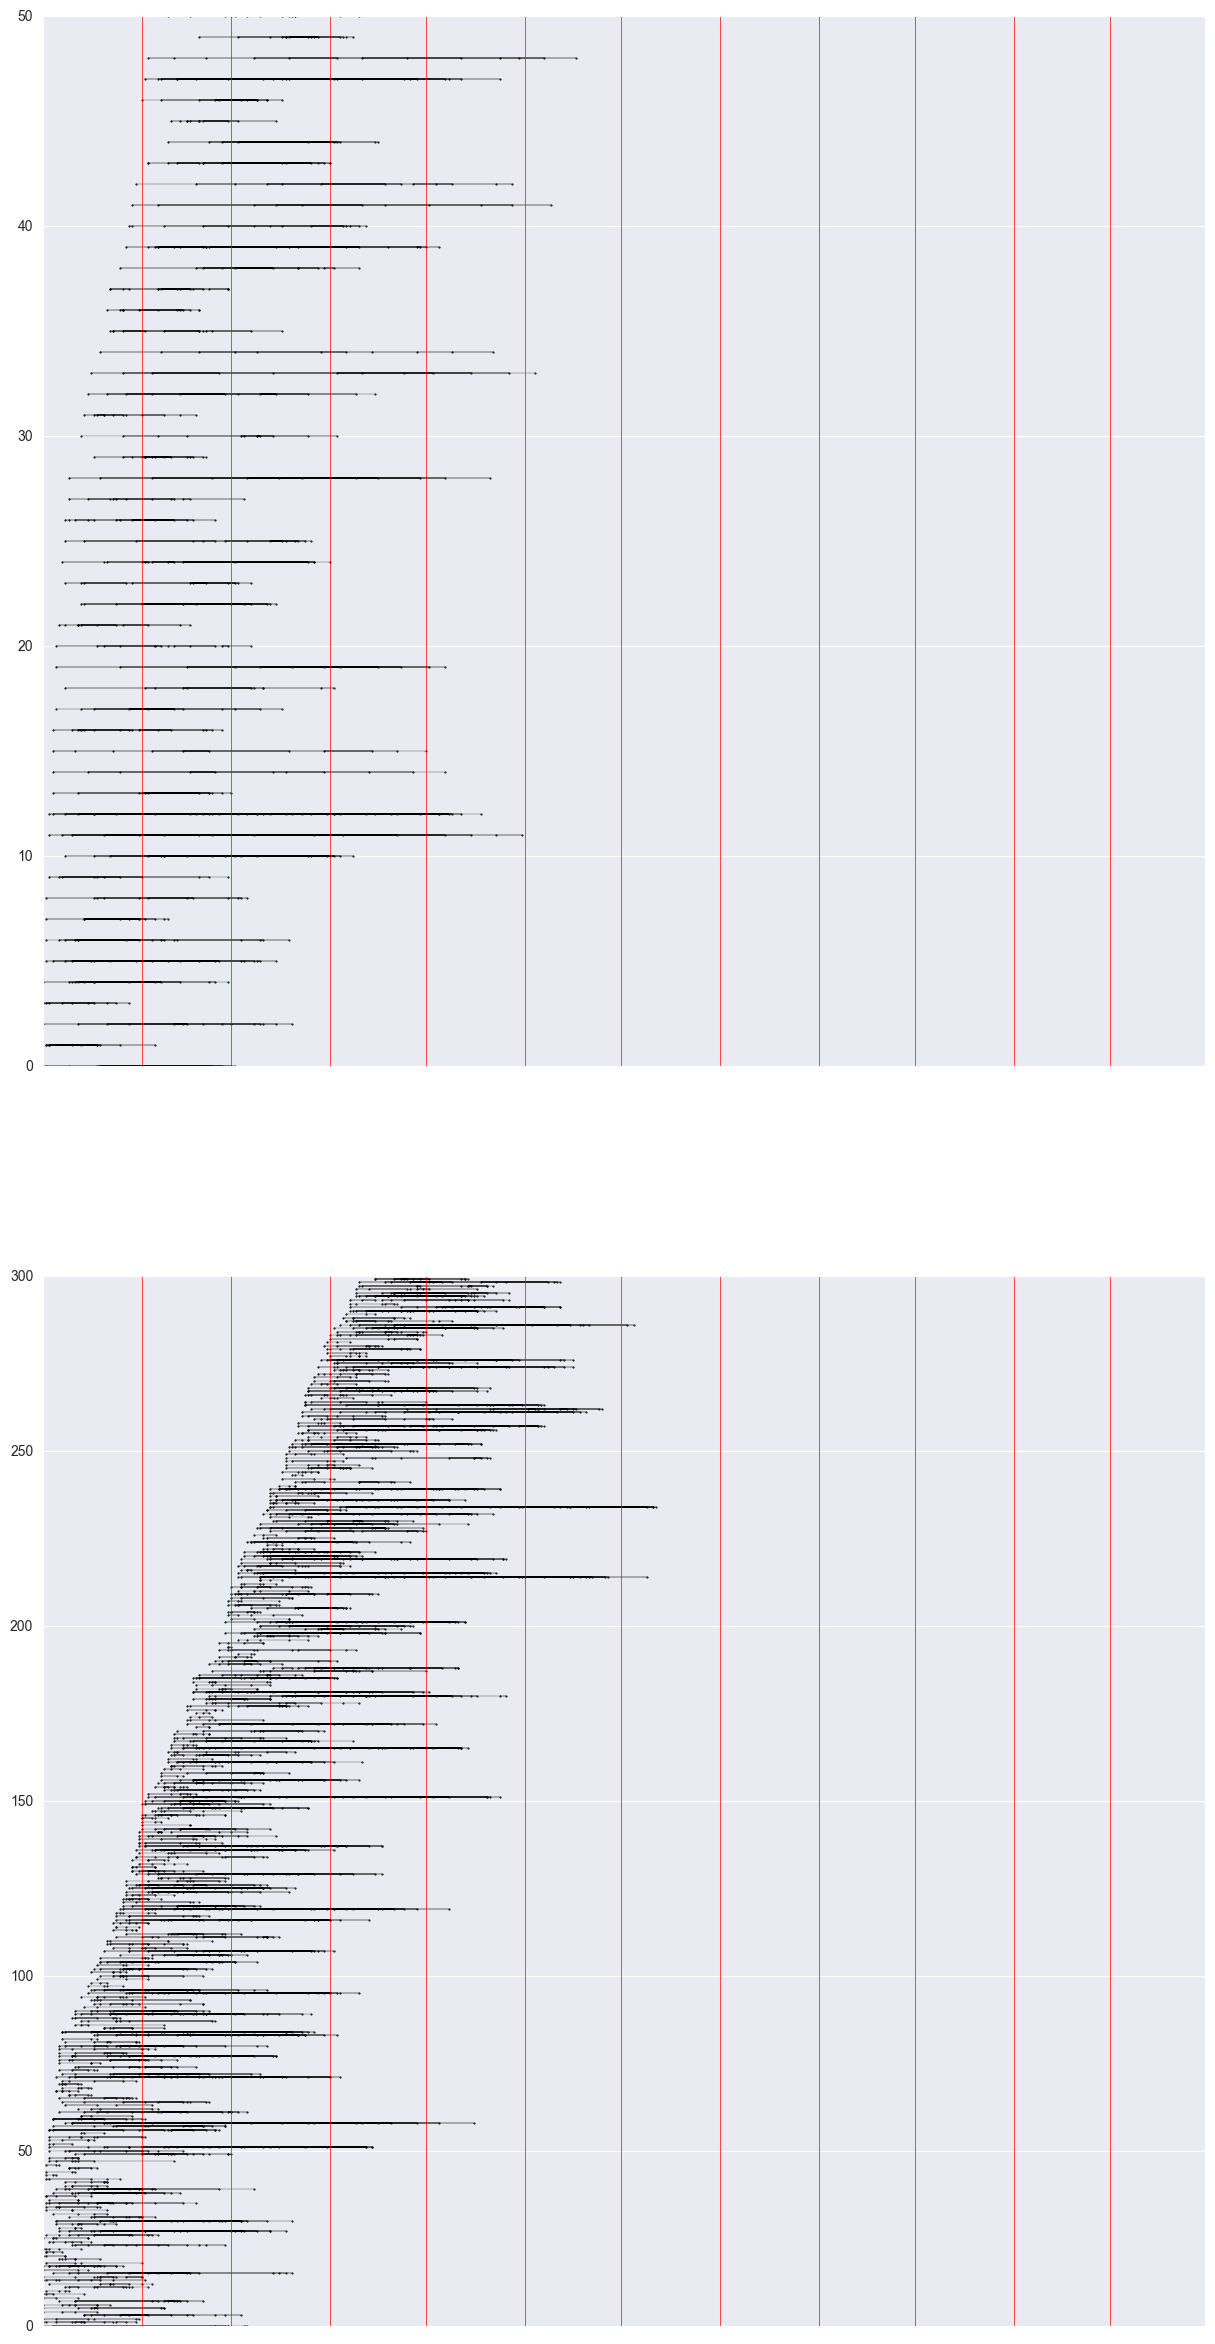

In [90]:
plt.figure(figsize=(15, 30))
plt_idx = 1
dist_transactions = [[], []]
for d in [df_non_fraud, df_fraud]:
    # d = d.loc[d['datetime'].apply(lambda date: date.month) < 7]
    # d = d.loc[d['datetime'].apply(lambda date: date.month) > 3]
    plt.subplot(2, 1, plt_idx)
    trans_idx = 0
    for card in df_all['card_number'].unique():
        card_times = d.loc[d['card_number'] == card, 'datetime']
        dist_transactions[plt_idx-1].extend([(card_times.iloc[i+1] - card_times.iloc[i]).days for i in range(len(card_times)-1)])
        if plt_idx == 2:
            num_c = 2
        else:
            num_c = 10
        if len(card_times) > num_c:
            card_times = card_times.parallel_apply(lambda date: date.date())
            card_times = matplotlib.dates.date2num(card_times)
            plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k.', markersize=1)
            plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k-', linewidth=0.2)
            trans_idx += 1
    min_date = matplotlib.dates.date2num(min(df_all['datetime']).date())
    max_date = matplotlib.dates.date2num(max(df_all['datetime']).date())
    plt.xlim([min_date, max_date])
    plt.xticks([])
    for m in range(1,13):
        datenum = matplotlib.dates.date2num(datetime(2021, m, 1))
        plt.plot(np.zeros(2)+datenum, [-1, 1000], 'r-', linewidth=0.5)
    if plt_idx == 1:
        plt.ylim([0,50])
    else:
        plt.ylim([0, 300])
    plt_idx += 1
plt.show()

In [85]:
prob_stay = np.zeros(2)
for k in range(2):

    dataset = [df_non_fraud, df_fraud][k]

    creditcards = dataset.loc[dataset['datetime'].parallel_apply(lambda d: d.month) > 3]
    creditcards = creditcards.loc[creditcards['datetime'].parallel_apply(lambda d: d.month) < 6]
    creditcard_counts = creditcards['card_number'].value_counts()
    creditcardIDs = creditcards['card_number']

    data = dataset.loc[dataset['datetime'].parallel_apply(lambda d: d.month) > 3]

    single = 0
    multi = 0
    for i in range(len(creditcards)):
        cc = creditcards.iloc[i]['card_number']
        dd = creditcards.iloc[i]['datetime']
        cond1 = data['card_number'] == cc
        cond2 = data['datetime'] > dd
        if len(data.loc[np.logical_and(cond1, cond2)]) == 0:
            single += 1
        else:
            multi += 1

    prob_stay[k] = multi/(single+multi)

    print('probability of doing another transaction:', prob_stay[k], '{}'.format(['non-fraud', 'fraud'][k]))

probability of doing another transaction: 0.6162017970797454 non-fraud
probability of doing another transaction: 0.8261351052048727 fraud


# Fraud behaviour

In [75]:
cards0 = df_non_fraud['card_number'].unique()
cards1 = df_fraud['card_number'].unique()

print('cards total:', len(np.union1d(cards0, cards1)))
print('fraud cards:', len(cards1))
print('intersection:', len(np.intersect1d(cards0, cards1)))

# go through the cards that were in both sets
cards0_1 = []
cards1_0 = []
cards010 = []
for cib in np.intersect1d(cards0, cards1):
    date0 = df_non_fraud.loc[df_non_fraud['card_number']==cib].iloc[0]['datetime']
    date1 = df_fraud.loc[df_fraud['card_number']==cib].iloc[0]['datetime']
    if date0 < date1:
        cards0_1.append(cib)
        # genuine purchases after fraud
        dates00 = df_non_fraud.loc[df_non_fraud['card_number']==cib].iloc[1:]['datetime']
        if len(dates00)>0:
            if sum(dates00>date1)>0:
                cards010.append(cib)
    else:
        cards1_0.append(cib)

print('first genuine then fraud: ', len(cards0_1))
print('first fraud then genuine: ', len(cards1_0))
print('genuine again after fraud: ', len(cards010))

prob_stay_after_fraud = len(cards010)/len(cards0_1)
print('prob of purchase after fraud: ', prob_stay_after_fraud)


cards total: 52976
fraud cards: 2049
intersection: 1025
first genuine then fraud:  586
first fraud then genuine:  439
genuine again after fraud:  312
prob of purchase after fraud:  0.5324232081911263


ValueError: max() arg is an empty sequence

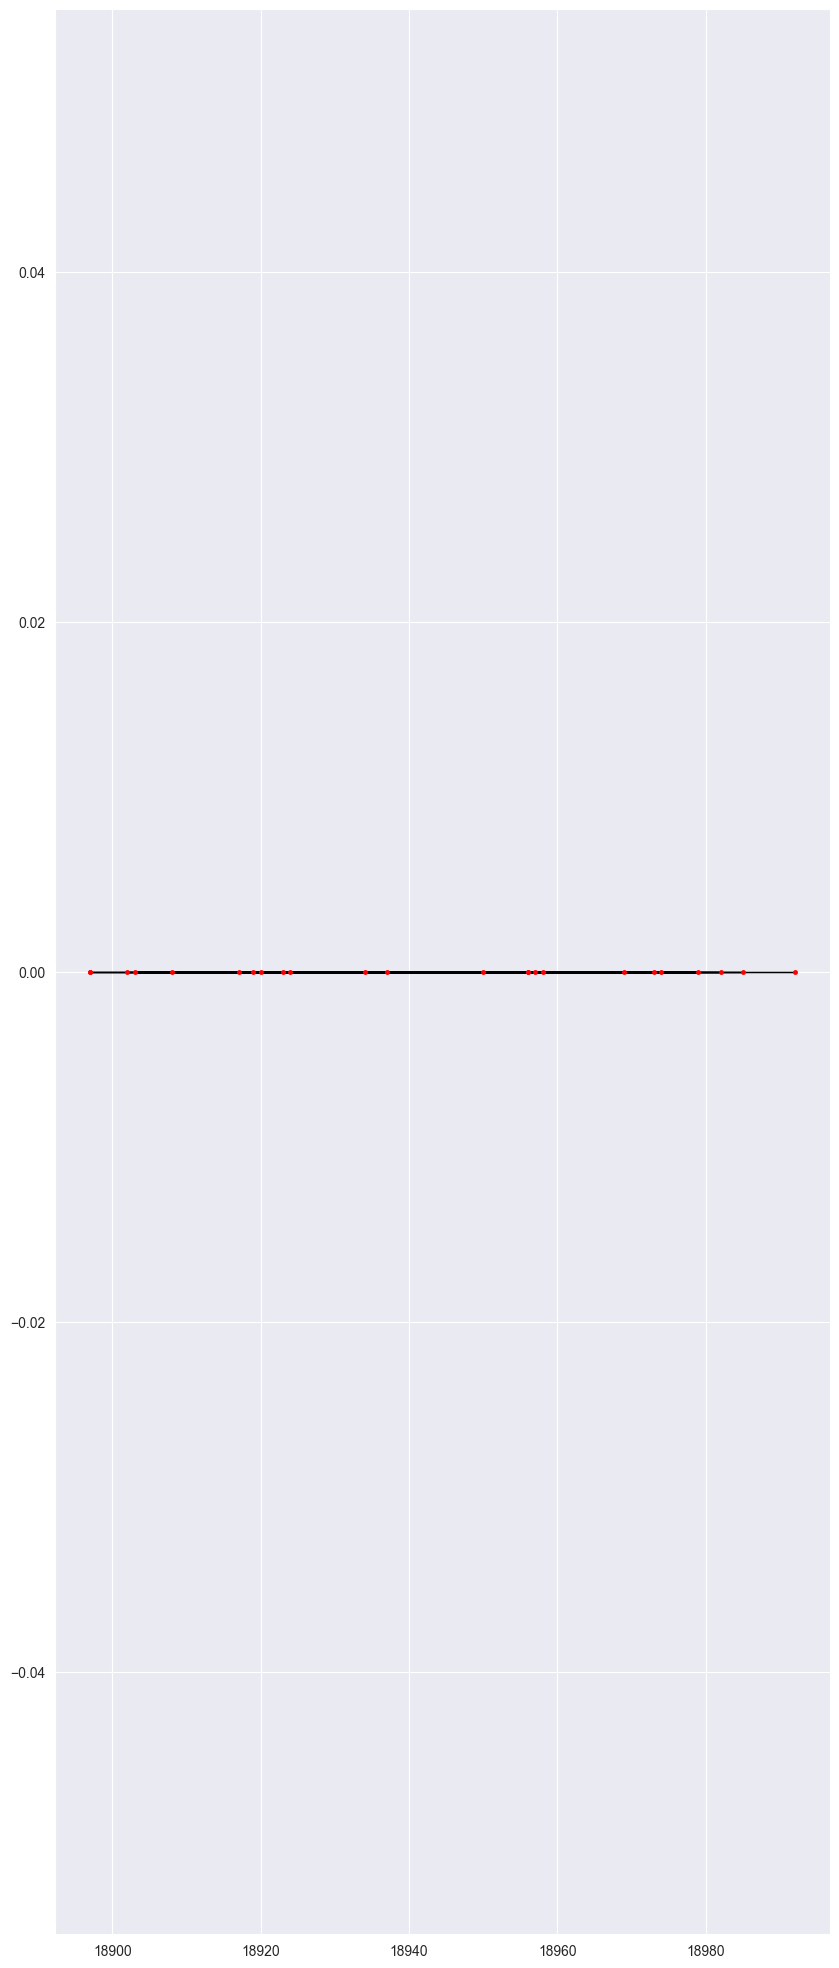

In [79]:
plt.figure(figsize=(10, 25))

dist_transactions = []
trans_idx = 0

data_compromised = df_fraud.loc[df_fraud['card_number'].parallel_apply(lambda cid: cid in np.intersect1d(cards0, cards1))]

no_trans_after_fraud = 0
trans_after_fraud = 0
for card in data_compromised['card_number'].unique():
    cards_used = data_compromised.loc[data_compromised['card_number'] == card, ['datetime', 'has_fraudulent_dispute']]
    dist_transactions.extend([(cards_used.iloc[i+1, 0] - cards_used.iloc[i, 0]).days for i in range(len(cards_used)-1)])

    card_times = cards_used['datetime'].parallel_apply(lambda date: date.date())
    card_times = matplotlib.dates.date2num(card_times)
    plt.plot(card_times, np.zeros(len(card_times)) + trans_idx, 'k-', linewidth=0.9)

    cond0 = cards_used['has_fraudulent_dispute'] == 0
    plt.plot(card_times[cond0], np.zeros(len(card_times[cond0])) + trans_idx, 'g.', markersize=5)

    cond1 = cards_used['has_fraudulent_dispute'] == 1
    plt.plot(card_times[cond1], np.zeros(len(card_times[cond1])) + trans_idx, 'r.', markersize=5)

    if max(cards_used.loc[cards_used['has_fraudulent_dispute']==0, 'datetime']) > max(cards_used.loc[cards_used['has_fraudulent_dispute']==1, 'datetime']):
        trans_after_fraud += 1
    else:
        no_trans_after_fraud += 1

    trans_idx += 1

min_date = matplotlib.dates.date2num(min(df_fraud['datetime']).date())
max_date = matplotlib.dates.date2num(max(df_fraud['datetime']).date())

plt.xticks([])
plt.ylim([0, trans_idx])

# print lines for months
for m in range(1,13):
    datenum = matplotlib.dates.date2num(datetime(2016, m, 1))
    plt.plot(np.zeros(2)+datenum, [-1, 1000], 'r-', linewidth=0.5)

plt_idx += 1
plt.show()

print("genuine transactions after fraud: ", trans_after_fraud)
print("fraud is the last transaction: ", no_trans_after_fraud)